In [1]:
import os
import json

# 경로 설정
train_annotation_dir = "C:/Users/USER/Desktop/low_light/annotations_train"
valid_annotation_dir = "C:/Users/USER/Desktop/low_light/annotations_valid"

# 클래스 목록을 저장할 세트
train_classes = set()
valid_classes = set()

# 어노테이션 파일을 읽어들여 고유 클래스 목록을 만든다
def extract_unique_classes(annotation_dir, class_set):
    for filename in os.listdir(annotation_dir):
        if filename.endswith('.json'):
            annotation_path = os.path.join(annotation_dir, filename)
            with open(annotation_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                annotations = data["Learning_Data_Info."]["Annotations"]
                for annotation in annotations:
                    class_id = annotation["Class_ID"]
                    class_set.add(class_id)

# 학습 데이터에서 고유 클래스 추출
extract_unique_classes(train_annotation_dir, train_classes)

# 검증 데이터에서 고유 클래스 추출
extract_unique_classes(valid_annotation_dir, valid_classes)

# 고유 클래스의 수와 목록을 출력
print(f"학습 데이터 총 클래스 종류 수: {len(train_classes)}")
print("학습 데이터 클래스 목록:")
for class_id in train_classes:
    print(class_id)

print(f"검증 데이터 총 클래스 종류 수: {len(valid_classes)}")
print("검증 데이터 클래스 목록:")
for class_id in valid_classes:
    print(class_id)

# 학습 데이터와 검증 데이터의 클래스가 동일한지 확인
if train_classes == valid_classes:
    print("학습 데이터와 검증 데이터는 동일한 종류의 클래스를 가지고 있습니다.")
else:
    print("학습 데이터와 검증 데이터는 동일한 종류의 클래스를 가지고 있지 않습니다.")
    
    # 차이를 출력
    only_in_train = train_classes - valid_classes
    only_in_valid = valid_classes - train_classes
    
    if only_in_train:
        print("학습 데이터에만 있는 클래스:")
        for class_id in only_in_train:
            print(class_id)
    
    if only_in_valid:
        print("검증 데이터에만 있는 클래스:")
        for class_id in only_in_valid:
            print(class_id)


학습 데이터 총 클래스 종류 수: 51
학습 데이터 클래스 목록:
Ladle
Glasses
Dish
Mouse
Clock
Motorcycle
Baseball_Glove
Remote
Seesaw
Weight
Cat
Labacon
Bench
Handbag
Cap
Frame
Camera
Book
Calendar
Dog
Racket
Scooter
Cup
Table
Wallet
Flowerpot
Pot
Station
Smart_Phone
Swing
Bottle
Laptop
Trash_Can
Ball
Bicycle
Car
Monitor
Folding_Fan
Truck
Boat
Umbrella
Stand_lamp
Mirror
Keyboard
Kettle
Human
Chair
Suitcase
Baseball_Bat
Can
Bus
검증 데이터 총 클래스 종류 수: 51
검증 데이터 클래스 목록:
Ladle
Glasses
Dish
Mouse
Clock
Motorcycle
Baseball_Glove
Remote
Seesaw
Weight
Cat
Labacon
Bench
Handbag
Cap
Frame
Camera
Book
Calendar
Dog
Racket
Scooter
Cup
Table
Wallet
Flowerpot
Pot
Station
Smart_Phone
Swing
Bottle
Laptop
Trash_Can
Ball
Car
Monitor
Folding_Fan
Bicycle
Truck
Boat
Umbrella
Stand_lamp
Keyboard
Mirror
Kettle
Human
Chair
Can
Baseball_Bat
Suitcase
Bus
학습 데이터와 검증 데이터는 동일한 종류의 클래스를 가지고 있습니다.


In [1]:
# 클래스 ID 및 레이블 매핑 정의
label2id = {
    'background': 0,
    'Ladle': 1,
    'Glasses': 2,
    'Dish': 3,
    'Mouse': 4,
    'Clock': 5,
    'Motorcycle': 6,
    'Baseball_Glove': 7,
    'Remote': 8,
    'Seesaw': 9,
    'Weight': 10,
    'Cat': 11,
    'Labacon': 12,
    'Bench': 13,
    'Handbag': 14,
    'Cap': 15,
    'Frame': 16,
    'Camera': 17,
    'Book': 18,
    'Calendar': 19,
    'Dog': 20,
    'Racket': 21,
    'Scooter': 22,
    'Cup': 23,
    'Table': 24,
    'Wallet': 25,
    'Flowerpot': 26,
    'Pot': 27,
    'Station': 28,
    'Smart_Phone': 29,
    'Swing': 30,
    'Bottle': 31,
    'Laptop': 32,
    'Trash_Can': 33,
    'Ball': 34,
    'Bicycle': 35,
    'Car': 36,
    'Monitor': 37,
    'Folding_Fan': 38,
    'Truck': 39,
    'Boat': 40,
    'Umbrella': 41,
    'Stand_lamp': 42,
    'Mirror': 43,
    'Keyboard': 44,
    'Kettle': 45,
    'Human': 46,
    'Chair': 47,
    'Suitcase': 48,
    'Baseball_Bat': 49,
    'Can': 50,
    'Bus': 51
}

# 반대 매핑 생성
id2label = {v: k for k, v in label2id.items()}

### custom dataset

In [2]:
import json
import torch
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torchvision.transforms as T
from skimage.draw import polygon2mask

class CustomDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        
        
        self.id2label = {v: k for k, v in label2id.items()}  # ID를 레이블로 매핑

        self.label_list = os.listdir(self.ann_dir)
        self.img_paths = []
        self.ann_paths = []
        
        # 미리 경로 계산
        for label in self.label_list:
            with open(os.path.join(self.ann_dir, label), 'r', encoding='utf-8') as f:
                img_info = json.load(f)
            img_filename = img_info["Source_Data_Info."]["Source_Data_ID"] + "." + img_info["Source_Data_Info."]["File_Extension"]
            img_path = os.path.join(self.img_dir, img_filename)
            self.img_paths.append(img_path)
            self.ann_paths.append(os.path.join(self.ann_dir, label))

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        ann_path = self.ann_paths[idx]
        
        with open(ann_path, 'r', encoding='utf-8') as f:
            img_info = json.load(f)
        
        image = Image.open(img_path).convert('RGB')
        mask = np.full((image.height, image.width), 0, dtype=np.int32)  # 초기값을 0으로 설정
        
        for annotation in img_info["Learning_Data_Info."]["Annotations"]:
            class_id = self.get_class_index(annotation["Class_ID"])
            coords = [(y, x) for x, y in zip(annotation["Type_value"][::2], annotation["Type_value"][1::2])]
            
            # 좌표가 이미지 경계를 벗어나는지 확인
            out_of_bounds_coords = [(x, y) for y, x in coords if x < 0 or x >= image.width or y < 0 or y >= image.height]
            if out_of_bounds_coords:
                coords = [(max(0, min(image.height - 0.1, y)), max(0, min(image.width - 0.1, x))) for y, x in coords] # 이미지 벗어나는 좌표 클리핑
            
            poly_mask = polygon2mask((image.height, image.width), coords)
            mask[poly_mask] = class_id
                
        if self.transforms:
            augmented = self.transforms(image=np.array(image), mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask
    
        # if self.transforms:
        #     image = self.transforms(image)
        
        # mask = torch.tensor(mask, dtype=torch.long)

        # return image, mask

    def get_class_index(self, label):
        return label2id.get(label, 0)  # 기본값 0 (배경)


In [3]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2 

# ### Data augmentation을 고려할 필요가 있음

# train_transforms = T.Compose([
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# val_transforms = T.Compose([
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])


train_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


# DataLoader 설정
train_dataset = CustomDataset("C:/Users/USER/Desktop/low_light/resized_image_train", "C:/Users/USER/Desktop/low_light/resized_annotations_train", transforms=train_transforms)
val_dataset = CustomDataset("C:/Users/USER/Desktop/low_light/resized_image_valid", "C:/Users/USER/Desktop/low_light/resized_annotations_valid", transforms=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=13, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=13, shuffle=False, num_workers=0)

Sample 1
Image shape: (288, 512, 3)
Mask shape: (288, 512)
Image path: C:/Users/USER/Desktop/low_light/resized_image_train\D3_220531_O03_L02A_E0004.jpg
Annotation path: C:/Users/USER/Desktop/low_light/resized_annotations_train\D3_220531_O03_L02A_E0004.json
Unique mask values: [ 0 18]


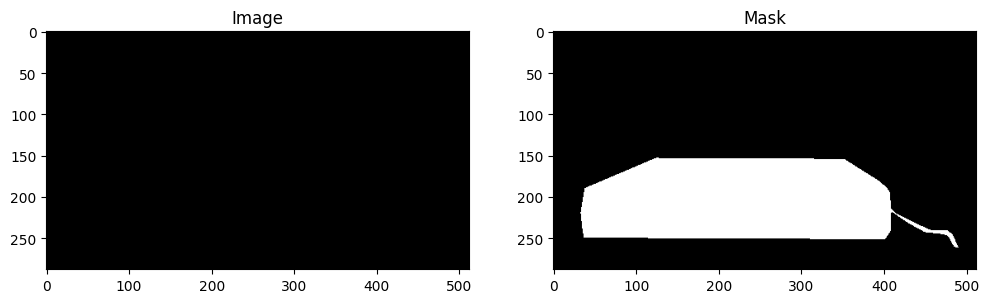

Sample 2
Image shape: (288, 512, 3)
Mask shape: (288, 512)
Image path: C:/Users/USER/Desktop/low_light/resized_image_train\D3_220603_I01_L09A_E0004.jpg
Annotation path: C:/Users/USER/Desktop/low_light/resized_annotations_train\D3_220603_I01_L09A_E0004.json
Unique mask values: [ 0 39]


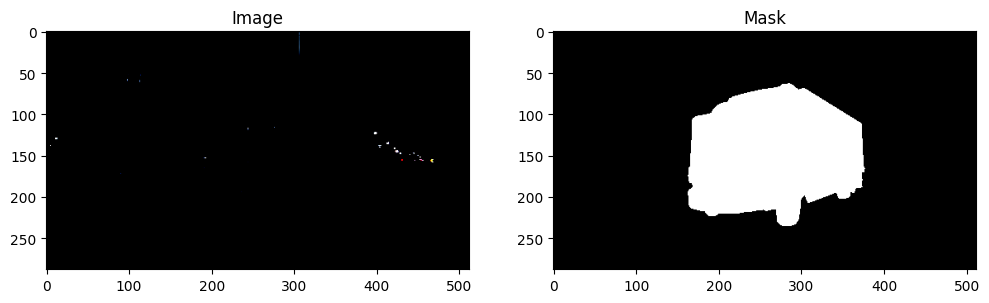

Sample 3
Image shape: (288, 512, 3)
Mask shape: (288, 512)
Image path: C:/Users/USER/Desktop/low_light/resized_image_train\D3_220603_O03_L03A_E0004.jpg
Annotation path: C:/Users/USER/Desktop/low_light/resized_annotations_train\D3_220603_O03_L03A_E0004.json


Unique mask values: [0 3]


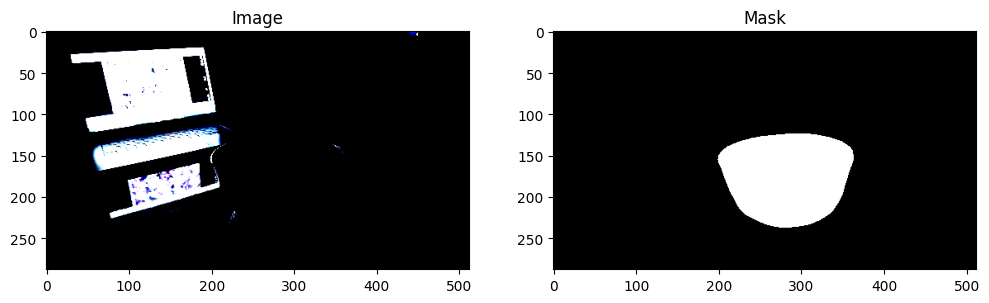

Sample 4
Image shape: (288, 512, 3)
Mask shape: (288, 512)
Image path: C:/Users/USER/Desktop/low_light/resized_image_train\D3_220606_O03_L04A_E0006.jpg
Annotation path: C:/Users/USER/Desktop/low_light/resized_annotations_train\D3_220606_O03_L04A_E0006.json
Unique mask values: [ 0 39]


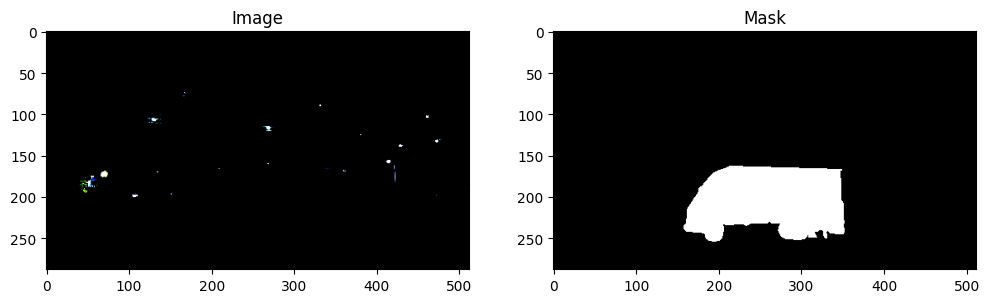

Sample 5
Image shape: (288, 512, 3)
Mask shape: (288, 512)
Image path: C:/Users/USER/Desktop/low_light/resized_image_train\D3_220606_O03_L04A_E0038.jpg
Annotation path: C:/Users/USER/Desktop/low_light/resized_annotations_train\D3_220606_O03_L04A_E0038.json


Unique mask values: [ 0 35]


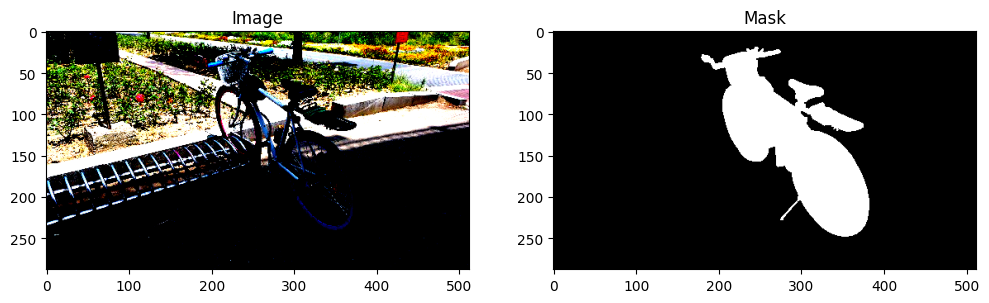

In [14]:
# 이미지 변환 설정
import matplotlib.pyplot as plt
train_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 설정
train_dataset = CustomDataset(
    "C:/Users/USER/Desktop/low_light/resized_image_train", 
    "C:/Users/USER/Desktop/low_light/resized_annotations_train", 
    transforms=train_transforms
)

def check_sample_data(dataset, num_samples=5):
    for i in range(num_samples):
        idx = 1 + i

        image, mask = dataset[i]
        
        image_np = image.numpy().transpose(1, 2, 0)
        mask_np = mask.numpy()
        
        print(f"Sample {i+1}")
        print("Image shape:", image_np.shape)
        print("Mask shape:", mask_np.shape)
        print("Image path:", dataset.img_paths[idx])
        print("Annotation path:", dataset.ann_paths[idx])
        print("Unique mask values:", np.unique(mask_np))
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title("Image")
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title("Mask")
        
        plt.show()

# 샘플 데이터 확인 실행
check_sample_data(train_dataset)

In [4]:
# Pre-trained models
# MODEL_CHECKPOINT = 'nvidia/mit-b0'
# MODEL_CHECKPOINT = 'nvidia/mit-b1'
# MODEL_CHECKPOINT = 'nvidia/mit-b2'
MODEL_CHECKPOINT = 'nvidia/mit-b3'
# MODEL_CHECKPOINT = 'nvidia/mit-b4'
# MODEL_CHECKPOINT = 'nvidia/mit-b5'
# MODEL_CHECKPOINT = 'nvidia/segformer-b4-finetuned-cityscapes-1024-1024'


LR = 0.00006

In [5]:
from transformers import SegformerForSemanticSegmentation


# 모델 초기화
model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(id2label),  # 클래스 수 지정
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # 사전 훈련된 모델과 크기 불일치 무시
)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_name = "nvidia/segformer-b3-finetuned-cityscapes-1024-1024"
# model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# # 모델의 헤드 클래스 수를 변경
# model.config.num_labels = 13  # fine-tuning 데이터셋의 클래스 수에 맞게 변경
# model.decode_head.classifier = torch.nn.Conv2d(768, model.config.num_labels, kernel_size=1)  # 768은 B3의 내부 차원 수
# model.load_state_dict(torch.load("C:/Users/USER/Downloads/512288.pth", map_location=device))



c:\Users\USER\anaconda3\envs\torch_seg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should proba

In [6]:
# start_epoch = 6  # 시작 에폭 설정
# num_epochs = 10  # 총 학습 에폭 설정
import wandb
wandb.init(project="low_light", id='b3')

# # wandb 초기화
# wandb.init(project="uncategorized_project", resume="allow", id="lemon-cherry-45")
# wandb.config.update({
#     "epochs": num_epochs,
#     "batch_size": 16,
#     "start_epoch": start_epoch,
#     "learning_rate": 0.00006,
# })

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chldyddn98 (choiyw). Use `wandb login --relogin` to force relogin


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_metric
import wandb
import evaluate  # evaluate 라이브러리를 사용합니다

import os

# 저장할 폴더 지정 및 생성
model_save_path = "saved_models"
model_filename = "best_model.pth"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
full_model_path = os.path.join(model_save_path, model_filename)



# # wandb 초기화
# wandb.init(project="uncategorized_project", resume="allow", id="lemon-cherry-45")
# wandb.config.update({
#     "epochs": num_epochs,
#     "batch_size": 16,
#     "start_epoch": start_epoch,
#     "learning_rate": 0.00006,
# })

# 설정 변수
gradient_accumulation_steps = 4
best_mean_iou = 0.0

iou_metric = evaluate.load("mean_iou", trust_remote_code=True)  # evaluate 라이브러리를 사용하여 메트릭 로드

# validation
def validate_amp(model, val_loader, device, num_labels=52, ignore_index=255):
    model.eval()  # 모델을 평가 모드로 전환
    total_loss = 0
    total_correct = 0
    total_pixels = 0
    iou_metric = evaluate.load("mean_iou", trust_remote_code=True)  # 각 검증 루프마다 메트릭을 새로 초기화
    
    with torch.no_grad():  
        pbar = tqdm(total=len(val_loader), desc="Validating", unit="batch")  # tqdm을 사용하여 검증 진행 상황 표시
        for batch in val_loader:
            pixel_values = batch[0].to(device).float()  # 입력 데이터를 장치로 이동
            labels = batch[1].to(device).long()  # 라벨 데이터를 장치로 이동
            
            with autocast():  # 자동 혼합 정밀도(AMP)를 사용하여 연산
                outputs = model(pixel_values=pixel_values)  
                logits = outputs.logits  # 로짓 값
                upsampled_logits = F.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)  # 로짓을 라벨 크기로 보간
                loss = F.cross_entropy(upsampled_logits, labels, ignore_index=255)  # 교차 엔트로피 손실 계산
                
            total_loss += loss.item()  # 총 손실 계산
            predicted = upsampled_logits.argmax(dim=1)  # 예측값 계산

             # Pixel accuracy 계산
            correct = (predicted == labels).sum().item()
            total = (labels != ignore_index).sum().item()
            total_correct += correct
            total_pixels += total

            iou_metric.add_batch(predictions=predicted, references=labels)  # 메트릭에 배치 추가
            pbar.update(1) 

        pbar.close()  

    avg_loss = total_loss / len(val_loader)  # 평균 손실 계산
    mean_iou = iou_metric.compute(num_labels=num_labels, ignore_index=ignore_index)  # Mean IoU 계산
    pixel_accuracy = total_correct / total_pixels  # Pixel Accuracy 계산
    return avg_loss, mean_iou, pixel_accuracy  # 평균 손실과 Mean IoU 반환

# 모델, optimizer, device 설정
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)  # AdamW 옵티마이저 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)  # AdamW 옵티마이저 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # CUDA 또는 CPU 장치 설정
model.to(device)  
scaler = GradScaler()  # GradScaler 설정 (AMP를 위한 스케일러)

# 훈련 및 검증 루프
for epoch in range(10):
    model.train()  
    train_loss = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/10", unit="batch")  # tqdm을 사용하여 훈련 진행 상황 표시
    for idx, batch in enumerate(train_loader):
        images, masks = batch
        # print(f"Batch {idx} - Images Shape: {images.shape}, Masks Shape: {masks.shape}")
        # print(f"Images dtype: {images.dtype}, Masks dtype: {masks.dtype}")
        # print(f"Images min: {images.min()}, max: {images.max()}")
        # print(f"Masks unique values: {torch.unique(masks)}")
        pixel_values = batch[0].to(device).float()  # 입력 데이터를 장치로 이동
        labels = batch[1].to(device).long()  # 라벨 데이터를 장치로 이동

        optimizer.zero_grad(set_to_none=True)  # 옵티마이저의 기울기 초기화

        with autocast():  # 자동 혼합 정밀도(AMP)를 사용하여 연산
            outputs = model(pixel_values=pixel_values, labels=labels)  
            loss = outputs.loss / gradient_accumulation_steps  

        scaler.scale(loss).backward()  # 스케일된 손실에 대한 역전파

        if (idx + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)  # 스케일된 파라미터로 옵티마이저 스텝
            scaler.update()  # 스케일러 업데이트
            optimizer.zero_grad()  # 옵티마이저의 기울기 초기화

        train_loss += loss.item() * gradient_accumulation_steps  # 총 훈련 손실 계산
        pbar.update(1)  
        pbar.set_postfix(batch_loss=f"{loss.item():.4f}") 

    pbar.close()  
    val_loss, mean_iou, pixel_accuracy = validate_amp(model, val_loader, device)  # 검증 함수 호출
    wandb.log({"Validation Loss": val_loss, "Mean IOU": mean_iou, "Pixel Accuracy": pixel_accuracy})  # wandb에 검증 손실 및 Mean IoU 로깅

    print(f"Validation Loss: {val_loss:.4f}, Mean IOU: {mean_iou}, Pixel Accuracy:{pixel_accuracy}")  # 검증 손실 및 Mean IoU 출력

    # 모델 저장
    if mean_iou['mean_iou'] > best_mean_iou:
        best_mean_iou = mean_iou['mean_iou']  # 최고 Mean IoU 업데이트
        torch.save(model.state_dict(), full_model_path)  # 모델 상태 저장
        print(f"Saved best model to {full_model_path}")  # 모델 저장 위치 출력


INFO:datasets:PyTorch version 2.3.1 available.


KeyboardInterrupt: 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_metric
import wandb
import evaluate  # evaluate 라이브러리를 사용합니다

import os

# 저장할 폴더 지정 및 생성
model_save_path = "saved_models"
model_filename = "best_model.pth"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
full_model_path = os.path.join(model_save_path, model_filename)



# # wandb 초기화
# wandb.init(project="uncategorized_project", resume="allow", id="lemon-cherry-45")
# wandb.config.update({
#     "epochs": num_epochs,
#     "batch_size": 16,
#     "start_epoch": start_epoch,
#     "learning_rate": 0.00006,
# })

# 설정 변수
gradient_accumulation_steps = 4
best_mean_iou = 0.0


# Mean IoU 계산 함수 정의
def compute_mean_iou(predictions, references, num_labels, ignore_index):
    classes_in_labels = torch.unique(references)
    if ignore_index is not None:
        classes_in_labels = classes_in_labels[classes_in_labels != ignore_index]
    
    iou_list = []
    for cls in range(num_labels):
        if cls in classes_in_labels:
            intersection = torch.sum((predictions == cls) & (references == cls)).item()
            union = torch.sum((predictions == cls) | (references == cls)).item()
            iou = intersection / union if union != 0 else 0
            iou_list.append(iou)
    
    mean_iou = sum(iou_list) / len(iou_list) if iou_list else 0
    return mean_iou

def validate_amp(model, val_loader, device, num_labels=52, ignore_index=255):
    model.eval()  # 모델을 평가 모드로 전환
    total_loss = 0
    total_correct = 0
    total_pixels = 0
    iou_metric = evaluate.load("mean_iou", trust_remote_code=True)  # 각 검증 루프마다 메트릭을 새로 초기화
    
    with torch.no_grad():  
        pbar = tqdm(total=len(val_loader), desc="Validating", unit="batch")  # tqdm을 사용하여 검증 진행 상황 표시
        for batch in val_loader:
            pixel_values = batch[0].to(device).float()  # 입력 데이터를 장치로 이동
            labels = batch[1].to(device).long()  # 라벨 데이터를 장치로 이동
            
            with autocast():  # 자동 혼합 정밀도(AMP)를 사용하여 연산
                outputs = model(pixel_values=pixel_values)  
                logits = outputs.logits  # 로짓 값
                upsampled_logits = F.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)  # 로짓을 라벨 크기로 보간
                loss = F.cross_entropy(upsampled_logits, labels, ignore_index=ignore_index)  # 교차 엔트로피 손실 계산
                
            total_loss += loss.item()  # 총 손실 계산
            predicted = upsampled_logits.argmax(dim=1)  # 예측값 계산

            # Pixel accuracy 계산
            correct = (predicted == labels).sum().item()
            total = (labels != ignore_index).sum().item()
            total_correct += correct
            total_pixels += total

            iou_metric.add_batch(predictions=predicted, references=labels)  # 메트릭에 배치 추가
            pbar.update(1) 

        pbar.close()  

    avg_loss = total_loss / len(val_loader)  # 평균 손실 계산
    mean_iou = compute_mean_iou(predicted, labels, num_labels, ignore_index)  # Mean IoU 계산
    pixel_accuracy = total_correct / total_pixels  # Pixel Accuracy 계산
    return avg_loss, mean_iou, pixel_accuracy  # 평균 손실과 Mean IoU 반환

# 모델, optimizer, device 설정
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)  # AdamW 옵티마이저 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)  # AdamW 옵티마이저 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # CUDA 또는 CPU 장치 설정
model.to(device)  
scaler = GradScaler()  # GradScaler 설정 (AMP를 위한 스케일러)

# 훈련 및 검증 루프
for epoch in range(10):
    model.train()  
    train_loss = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/10", unit="batch")  # tqdm을 사용하여 훈련 진행 상황 표시
    for idx, batch in enumerate(train_loader):
        images, masks = batch
        # print(f"Batch {idx} - Images Shape: {images.shape}, Masks Shape: {masks.shape}")
        # print(f"Images dtype: {images.dtype}, Masks dtype: {masks.dtype}")
        # print(f"Images min: {images.min()}, max: {images.max()}")
        # print(f"Masks unique values: {torch.unique(masks)}")
        pixel_values = batch[0].to(device).float()  # 입력 데이터를 장치로 이동
        labels = batch[1].to(device).long()  # 라벨 데이터를 장치로 이동

        optimizer.zero_grad(set_to_none=True)  # 옵티마이저의 기울기 초기화

        with autocast():  # 자동 혼합 정밀도(AMP)를 사용하여 연산
            outputs = model(pixel_values=pixel_values, labels=labels)  
            loss = outputs.loss / gradient_accumulation_steps  

        scaler.scale(loss).backward()  # 스케일된 손실에 대한 역전파

        if (idx + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)  # 스케일된 파라미터로 옵티마이저 스텝
            scaler.update()  # 스케일러 업데이트
            optimizer.zero_grad()  # 옵티마이저의 기울기 초기화

        train_loss += loss.item() * gradient_accumulation_steps  # 총 훈련 손실 계산
        pbar.update(1)  
        pbar.set_postfix(batch_loss=f"{loss.item():.4f}") 

    pbar.close()  
    val_loss, mean_iou, pixel_accuracy = validate_amp(model, val_loader, device)  # 검증 함수 호출
    wandb.log({"Validation Loss": val_loss, "Mean IOU": mean_iou, "Pixel Accuracy": pixel_accuracy})  # wandb에 검증 손실 및 Mean IoU 로깅

    print(f"Validation Loss: {val_loss:.4f}, Mean IOU: {mean_iou}, Pixel Accuracy:{pixel_accuracy}")  # 검증 손실 및 Mean IoU 출력

    # 모델 저장
    if mean_iou > best_mean_iou:
        best_mean_iou = mean_iou  # 최고 Mean IoU 업데이트
        torch.save(model.state_dict(), full_model_path)  # 모델 상태 저장
        print(f"Saved best model to {full_model_path}")  # 모델 저장 위치 출력


INFO:datasets:PyTorch version 2.3.1 available.
Validating:   0%|          | 0/77 [00:00<?, ?batch/s]c:\Users\USER\anaconda3\envs\torch_seg\lib\site-packages\datasets\features\image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Validating: 100%|██████████| 77/77 [00:23<00:00,  3.33batch/s]


Validation Loss: 0.4149, Mean IOU: 0.2386798489105622, Pixel Accuracy:0.9439095323350695
Saved best model to saved_models\best_model.pth


Validating: 100%|██████████| 77/77 [00:23<00:00,  3.34batch/s]


Validation Loss: 0.2655, Mean IOU: 0.36313370021706015, Pixel Accuracy:0.9534513075086806
Saved best model to saved_models\best_model.pth


Validating: 100%|██████████| 77/77 [00:23<00:00,  3.25batch/s]


Validation Loss: 0.1769, Mean IOU: 0.38181354585729593, Pixel Accuracy:0.9615083889431424
Saved best model to saved_models\best_model.pth


Validating: 100%|██████████| 77/77 [00:23<00:00,  3.31batch/s]


Validation Loss: 0.1447, Mean IOU: 0.4566826248556588, Pixel Accuracy:0.9656272989908854
Saved best model to saved_models\best_model.pth


Validating: 100%|██████████| 77/77 [00:24<00:00,  3.11batch/s]


Validation Loss: 0.1216, Mean IOU: 0.48343442321522573, Pixel Accuracy:0.9687296956380208
Saved best model to saved_models\best_model.pth


Validating: 100%|██████████| 77/77 [00:23<00:00,  3.32batch/s]


Validation Loss: 0.1117, Mean IOU: 0.5307565760961814, Pixel Accuracy:0.9693580186631945
Saved best model to saved_models\best_model.pth


Validating: 100%|██████████| 77/77 [00:23<00:00,  3.32batch/s]


Validation Loss: 0.1065, Mean IOU: 0.5588471340541952, Pixel Accuracy:0.9705289713541667
Saved best model to saved_models\best_model.pth


Validating: 100%|██████████| 77/77 [00:23<00:00,  3.31batch/s]


Validation Loss: 0.1056, Mean IOU: 0.53011331539925, Pixel Accuracy:0.9703801879882813


Validating: 100%|██████████| 77/77 [00:23<00:00,  3.33batch/s]


Validation Loss: 0.1001, Mean IOU: 0.5226071634902133, Pixel Accuracy:0.9714131808810764


Validating: 100%|██████████| 77/77 [00:23<00:00,  3.32batch/s]

Validation Loss: 0.0923, Mean IOU: 0.5170286696430295, Pixel Accuracy:0.9733190511067709
